In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
dir_ = '../input/cornimage/Color Images'  # storing dataset path into a variable


ImportError: Could not find 'nvcuda.dll'. TensorFlow requires that this DLL be installed in a directory that is named in your %PATH% environment variable. Typically it is installed in 'C:\Windows\System32'. If it is not present, ensure that you have a CUDA-capable GPU with the correct driver installed.

In [3]:
BATCH, IMG_SIZE, SEED = 32, (160, 160), 42  # Assing custom  batch_size, img_size, seed

# Spliting dataset into training and testing data in batches
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_,
                                                              batch_size = BATCH, 
                                                              image_size = IMG_SIZE, 
                                                              shuffle = True,
                                                              validation_split = .2, 
                                                              subset = 'training',
                                                              seed = SEED)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_,
                                                              batch_size = BATCH, 
                                                              image_size = IMG_SIZE, 
                                                              shuffle = True,
                                                              validation_split = .2, 
                                                              subset = 'validation',
                                                              seed = SEED)

NameError: name 'tf' is not defined

In [4]:
# assining labels to a variable
classes = train_ds.class_names
classes

NameError: name 'train_ds' is not defined

In [5]:
# visualizing first batch of training data
for image, label in train_ds.take(1):
    plt.figure(figsize = (30, 30))
    for i in range(32):
        plt.subplot(6, 6, i+1)
        plt.imshow(image[i]/255.)
        plt.axis('off')
        plt.title(classes[label[i]])
    plt.show()

NameError: name 'train_ds' is not defined

In [6]:
# Building Model for data Preprocessing
model_pre_pro = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(60, 60),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

NameError: name 'tf' is not defined

In [7]:
# Building Model for data Agumentation
model_agu = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

NameError: name 'tf' is not defined

In [8]:
# Building Customized CNN model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(160, 160, 3)),
    model_pre_pro,
    model_agu,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), #input_shape=(160, 160, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(25, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(169, activation = 'sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(119, activation = 'tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(79, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(49, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax'),
])

# Model Summary
model.summary() 

NameError: name 'tf' is not defined

In [9]:
# Visualizing Customized CNN model
tf.keras.utils.plot_model(model,'corn.png', show_shapes=True, show_layer_names=True)

NameError: name 'tf' is not defined

In [10]:
# Model Compliation
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

NameError: name 'model' is not defined

In [11]:
# Training Model
EPOCHS = 100
hist = model.fit(train_ds, epochs = EPOCHS, verbose = 1)

NameError: name 'model' is not defined

In [12]:
# Training History
model_df=pd.DataFrame(hist.history)
model_df['epoch']=hist.epoch
print(model_df.head())

NameError: name 'hist' is not defined

NameError: name 'model_df' is not defined

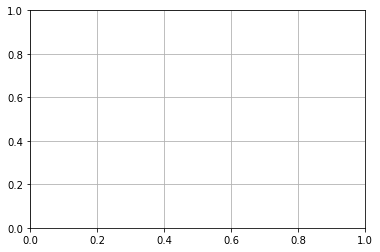

In [13]:
# Visualizing Training Accuracy
plt.grid(True)
plt.plot(model_df['epoch'],model_df['accuracy'],label='training accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.title('Training Accuracy')
plt.show()

NameError: name 'model_df' is not defined

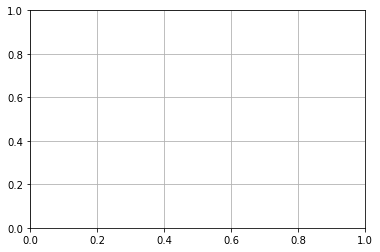

In [14]:
# Visualizing Training Loss
plt.grid(True)
plt.plot(model_df['epoch'],model_df['loss'],label='training loss', color = 'orange')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.title('Training Loss')
plt.show()

In [15]:
# Model Evaluatation
test_loss, test_accuracy = model.evaluate(test_ds)

NameError: name 'model' is not defined

In [16]:
# Printing Testing Accuracy and Loss
print(f'Test Accuracy = {test_accuracy}\nTest Loss = {test_loss}')

NameError: name 'test_accuracy' is not defined

In [17]:
# Making multiple batches of test data into single batch
num_batch=0
img=[]
label=[]
for image_batch,label_batch in test_ds:
    num_batch+=1
    img.append(image_batch)
    label.append(label_batch)
print(num_batch)
inputs=np.concatenate(img)
targets=np.concatenate(label)
print(inputs.shape)
print(targets.shape)

NameError: name 'test_ds' is not defined

In [18]:
# Predicting Data
pred = model.predict(inputs)

NameError: name 'model' is not defined

NameError: name 'pred' is not defined

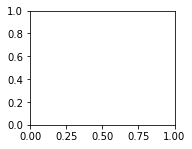

In [19]:
# Visualizing Predicted Data
plt.figure(figsize = (15, 50))
for i in range(100):
    plt.subplot(20, 5, i+1)
    pred_label = np.argmax(pred[i])
    test_label = targets[i]
    plt.imshow(inputs[i]/255.)
    plt.axis('off')
    if pred_label == test_label:
        color = 'green'
        plt.title('Correct classification',color=color)
    else:
        color = 'red'
        plt.title('WRONG classification',color=color)
plt.show()

In [20]:
# Confusion Matrix of Predicted Data and Actual Data
tf.math.confusion_matrix([np.argmax(i) for i in pred], targets)

NameError: name 'tf' is not defined